# Exploratory Data Analysis

## Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.neighbors import KernelDensity
from matplotlib.animation import FuncAnimation
import libpysal
import pysal.explore
import matplotlib.patches as  mpatches
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
%matplotlib inline

/Applications/anaconda3/envs/dsi/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
# Change this variable to 0 if you use jupyter notebook, or 1 if you use google colab
use_colab = 0

import os
if use_colab:
    from google.colab import files
    import io

if os.path.exists('dataset'):
    print('Dataset folder exists')
else:
    print('Dataset folder not exists. A dataset folder will be created.')
    os.mkdir('dataset')

def file_exists(parent_directory, file_name):
    path = os.path.join(parent_directory, file_name)
    if os.path.exists(path):
        return 1
    else:
        return 0
    
def read_csv_file(use_colab, file_name):
    if file_exists('dataset', file_name):
        return pd.read_csv('dataset/'+file_name)
    else:
        print("Please upload the file or create one by running previous section's csv export.")
        if use_colab:
            print("Please upload file: {}".format(file_name))
            upload_file = files.upload()
            return pd.read_csv(io.BytesIO(upload_file[file_name]))

Dataset folder exists


In [3]:
train = read_csv_file(use_colab, 'train_cleaned.csv')
test = read_csv_file(use_colab, 'test_cleaned.csv')
weather = read_csv_file(use_colab, 'weather_cleaned.csv')
spray = read_csv_file(use_colab, 'spray.csv')

In [4]:
# Set Date column as index
## Write function to be run on both train and test set later on
def datetime_setter(df):    
    df['Date'] = pd.to_datetime(df['Date'], format=("%Y-%m-%d")).copy()
    df.set_index(keys=['Date'], inplace=True)

In [5]:
datetime_setter(train)
datetime_setter(test)
datetime_setter(weather)
datetime_setter(spray)

## Correlation Matrix

We will now set up our data to observe the inter-correlations so that we may prioritise our analysis.

In [6]:
# Merge Weather and Training Dataset
weather_train = weather.merge(train, on=['Date', 'week_of_year'])
weather_train.head(2)

Tmax  Tmin  Tavg  DewPoint  WetBulb  Heat  Cool  AvgSpeed  Depart  \
Date                                                                            
2007-05-29  88.0  62.5  75.5      58.5     65.5   0.0  10.5      6.95      10   
2007-05-29  88.0  62.5  75.5      58.5     65.5   0.0  10.5      6.95      10   

            Sunset  Sunrise  Precip_1  Precip_2  week_of_year  \
Date                                                            
2007-05-29    1917      421       0.0       0.0            22   
2007-05-29    1917      421       0.0       0.0            22   

                           Species  Trap  Latitude  Longitude  NumMosquitos  \
Date                                                                          
2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991             1   
2007-05-29          CULEX RESTUANS  T002  41.95469 -87.800991             1   

            WnvPresent  
Date                    
2007-05-29           0  
2007-05-29           0

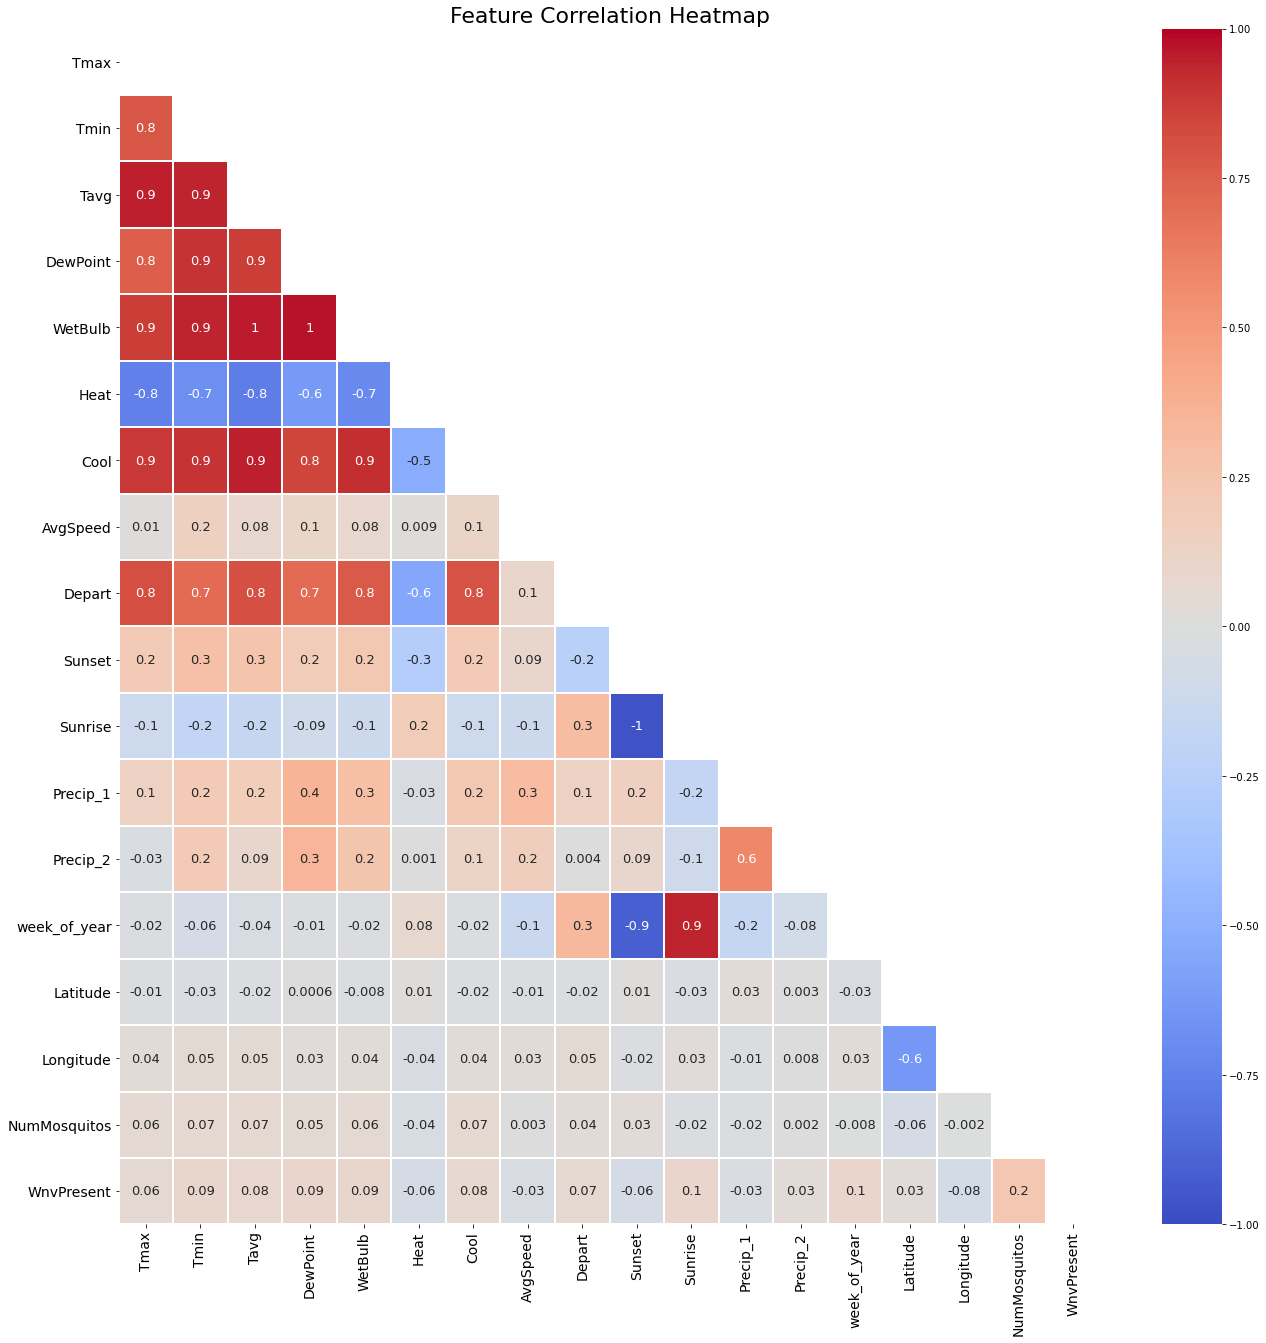

In [7]:
fix, ax = plt.subplots(figsize=(22,22))

mask = np.zeros_like(weather_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(weather_train.corr(), mask=mask, ax=ax, cmap='coolwarm',
                 vmin=-1, vmax=1,
                 linewidth=1,
                 annot=True, annot_kws={'size':'13'},
                 fmt='.1g'
                )

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

ax.set_title('Feature Correlation Heatmap', fontsize=22);

Observations:
- There are high multicollinearity on **temperature related features**. This does not come as a surprise as it is sensible to have higher Tmin and Tmax on a hotter day, for example. This means, we should remove all and leave one temperature correlated feature in our modelling especially if we are using Logistic Regression.
- Column 'Depart' also has a high correlation to the day temperature as the column represents difference in temperature compared to an average day. 
- **Month, Week of Year, Sunrise and Sunset** timing also has correlation as Sunset timing is gets earlier nearing the end of fall and coming of winter months while Sunrise gets later due to winter solstice ([source](https://earthsky.org/earth/winter-solstice-and-late-sunrise#:~:text=For%20the%20Southern%20Hemisphere%2C%20the,this%20month%20for%20that%20hemisphere.)).
- There is no single element with high correlation with WnvPresent. This is our main motivation to generate more feature that has a higher correlation to better predict presence of WNV. 

## Time Series Analysis

### Mosquito Population and WNV Presence

It is widely believed that increase in mosquito population increase the chance of the spread of mosquito related diseases such as West Nile Virus ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6085780/)). In this section, we will observe how this trend surface in the city of Chicago.

In [8]:
mos_pop_df = pd.DataFrame(index=weather.index)
mos_pop_df = mos_pop_df.merge(train.groupby(['Date'])[['NumMosquitos', 'WnvPresent']].sum(),
                              left_index=True, right_index=True, how='left').fillna(0)

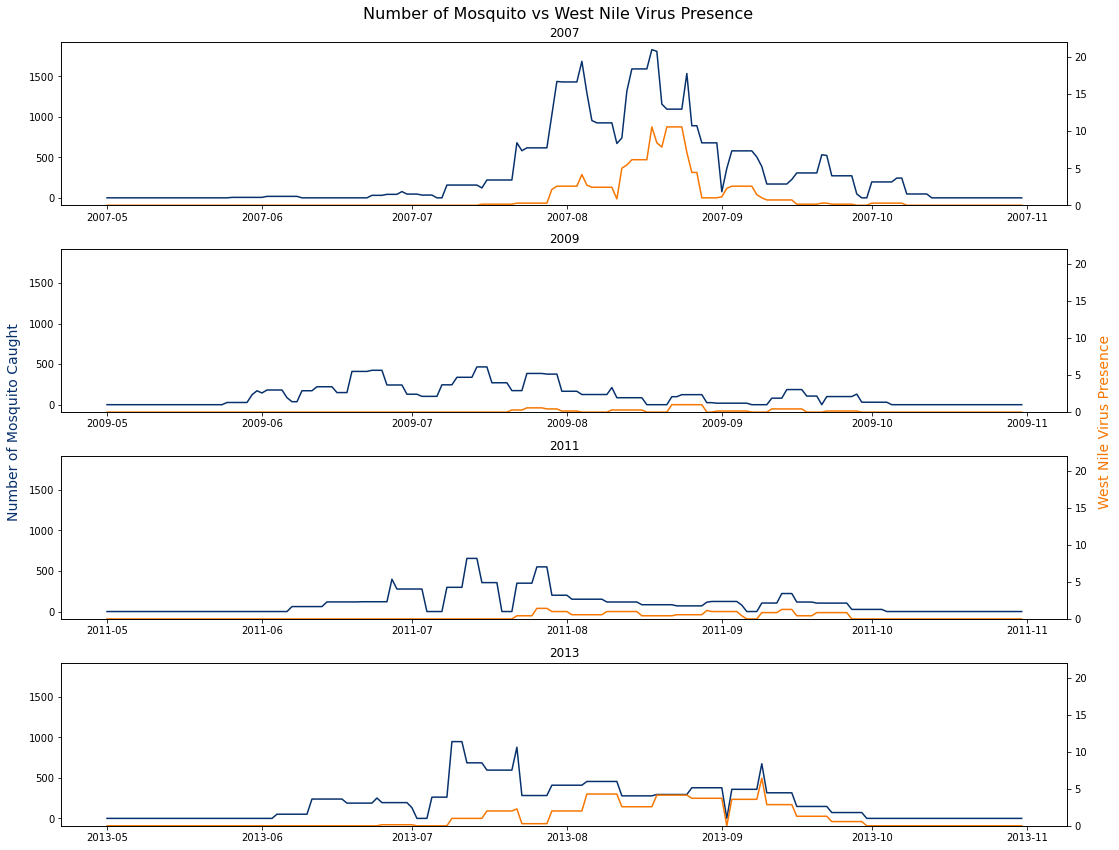

In [9]:
years = ['2007', '2009', '2011', '2013']
fig, ax = plt.subplots(nrows=4, figsize=(15,12), sharey=True)
ax=ax.ravel()
plt.suptitle('Number of Mosquito vs West Nile Virus Presence', fontsize=16)
for i, year in enumerate(years):
    ax[i].set_title(str(year), fontsize=12)
    ax[i].plot(mos_pop_df.loc[str(year)].index,
               mos_pop_df.loc[str(year)]['NumMosquitos'].rolling(7, center=True).mean().fillna(mos_pop_df.loc[str(year)]['NumMosquitos'][0]),
               color='#07316c')
    ax2=ax[i].twinx()
    ax2.plot(mos_pop_df.loc[str(year)].index,
               mos_pop_df.loc[str(year)]['WnvPresent'].rolling(7, center=True).mean().fillna(mos_pop_df.loc[str(year)]['WnvPresent'][0]),
               color='#f67600')
    ax2.set_ylim([0, 22])
fig.text(-0.01, 0.5, 'Number of Mosquito Caught', va='center', rotation='vertical', color='#07316c', fontsize=14)
fig.text(1, 0.5,  'West Nile Virus Presence', va='center', rotation='vertical', color='#f67600', fontsize=14)
plt.tight_layout()

**Observation:**
- West Nile Virus presence peaks roughly about a month of the peak population of mosquitos. 
- As expected, a higher concentration of mosquitoes corresponds to a higher WNV presence.

### Temperature

Ambient temperature is known to have an effect in mosquito population. Higher temperature is often associated with reduction of egg-laying and incubation period of mosquito larvae. This means higher temperature leads to mosquito having to spend less time in immature state (larvae), therefore, able to reproduce earlier and produce even more mosquitos ([source](https://insectcop.net/weather-temperature-affect-mosquito-population/#:~:text=This%20is%20because%20higher%20temperatures,impact%20on%20the%20mosquito%20population.)). 

Hence, we would like to see if there is any direct correlation between average day temperature to the number of mosquito being caught.

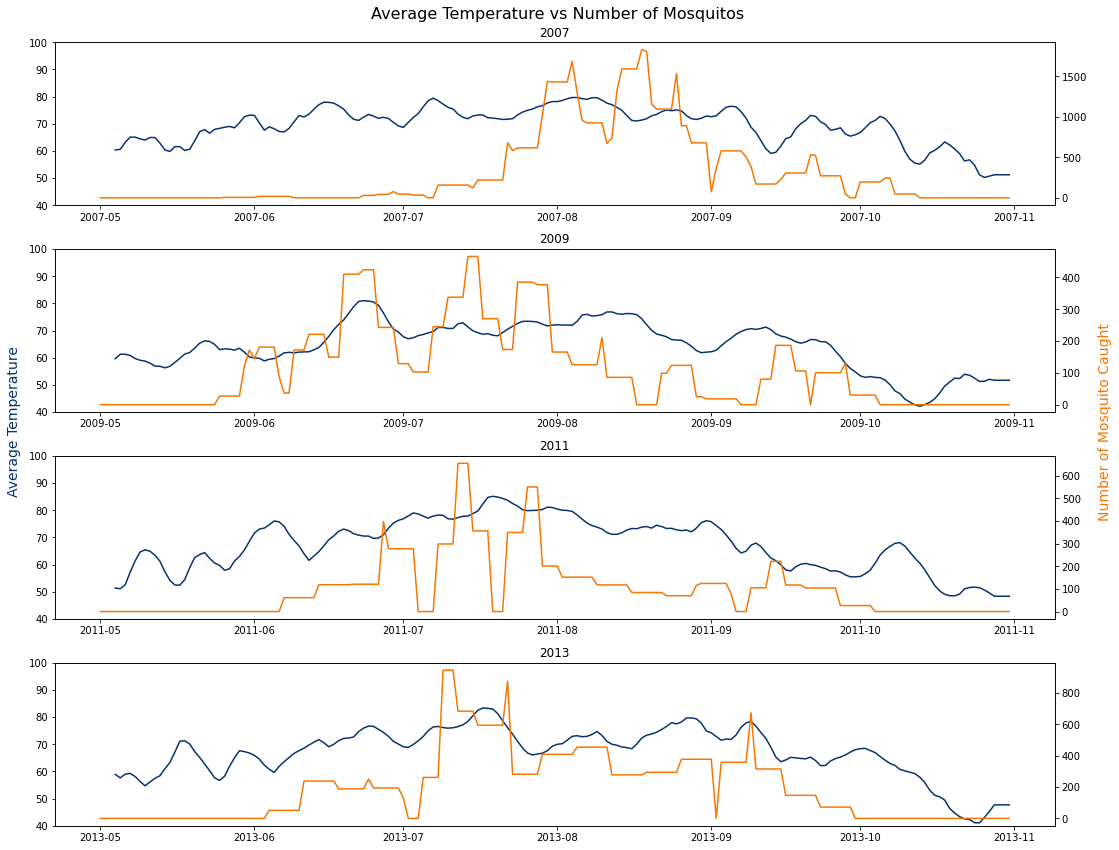

In [10]:
years = ['2007', '2009', '2011', '2013']
fig, ax = plt.subplots(nrows=4, figsize=(15,12))
ax=ax.ravel()
plt.suptitle('Average Temperature vs Number of Mosquitos', fontsize=16)
for i, year in enumerate(years):
    ax[i].set_title(str(year), fontsize=12)
    ax[i].plot(weather.loc[str(year)].index,
               weather.loc[str(year)]['Tavg'].rolling(7, center=True).mean().fillna(method='ffill'),
               color='#07316c')
    ax[i].set_ylim([40, 100])
    ax2=ax[i].twinx()
    ax2.plot(mos_pop_df.loc[str(year)].index,
               mos_pop_df.loc[str(year)]['NumMosquitos'].rolling(7, center=True).mean().fillna(mos_pop_df.loc[str(year)]['NumMosquitos'][0]),
               color='#f67600')
    
fig.text(-0.01, 0.5, 'Average Temperature', va='center', rotation='vertical', color='#07316c', fontsize=14)
fig.text(1, 0.5,  'Number of Mosquito Caught', va='center', rotation='vertical', color='#f67600', fontsize=14)
plt.tight_layout()

**Observations:**
- Based on the charts above, population of mosquito has increased as the average temperature surpassed > 60$^\circ$F marks. The population may fluctuate over the course of few weeks but it was able to sustain before it drops as the temperature drops in October. 

Note: 'Number of Mosquito' is plotted not in the same scale year on year. 

### Precipitation

Imature form of mosquito requires some form of water puddle to incubate and grow to be adult mosquito ([source](https://link.springer.com/chapter/10.1007/978-3-642-88533-4_6)). It took just-hatched larvae as little as 5 days to be a pupae before developing into an adult mosquito 2-3 days later ([source](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf)). Therefore, we can expect about 7-14 days from the increase of water puddle presence to the increase in mosquito population. 

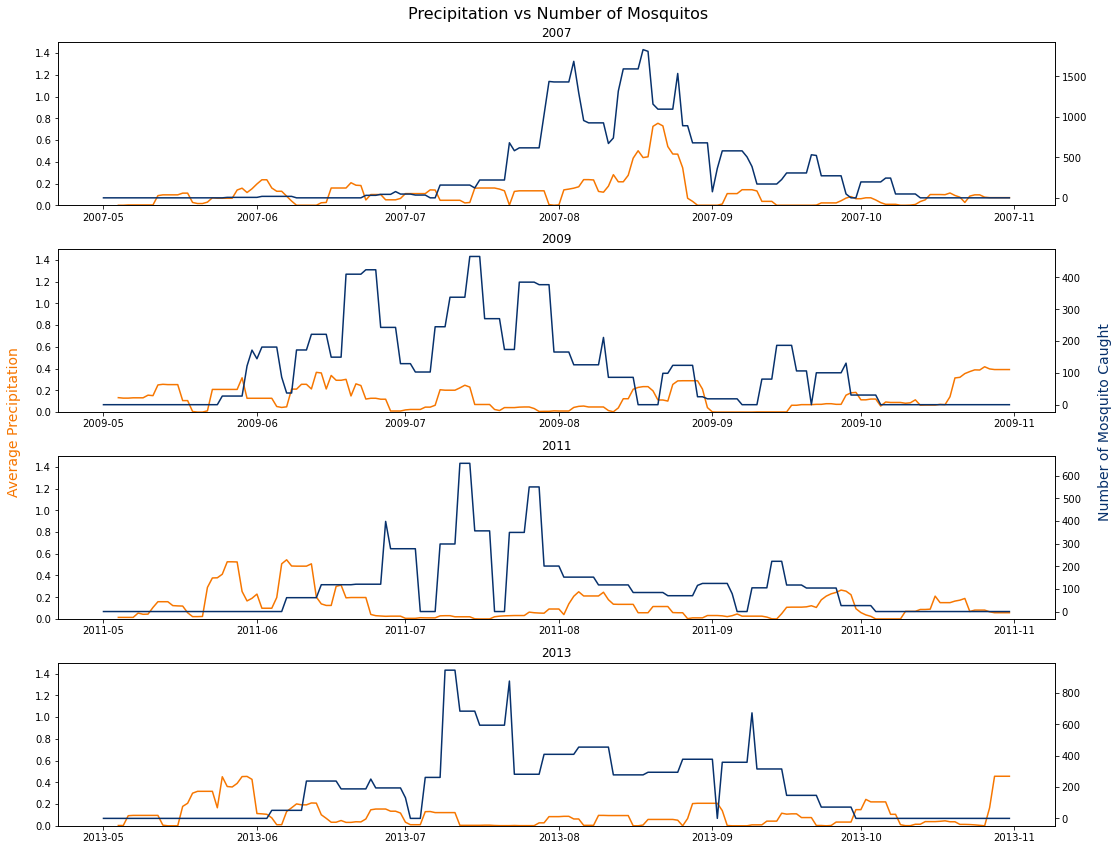

In [11]:
years = ['2007', '2009', '2011', '2013']
fig, ax = plt.subplots(nrows=4, figsize=(15,12), sharey=True)
ax=ax.ravel()
plt.suptitle('Precipitation vs Number of Mosquitos', fontsize=16)
for i, year in enumerate(years):
    ax[i].plot(weather.loc[str(year)].index,
               weather.loc[str(year)]['Precip_2'].rolling(7, center=True).mean().fillna(method='ffill'),
               color='#f67600')
    ax2=ax[i].twinx()
    ax[i].set_ylim([0, 1.5])
    ax2.set_title(str(year), fontsize=12)
    ax2.plot(mos_pop_df.loc[str(year)].index,
               mos_pop_df.loc[str(year)]['NumMosquitos'].rolling(7, center=True).mean().fillna(mos_pop_df.loc[str(year)]['NumMosquitos'][0]),
               color='#07316c')
    

fig.text(-0.01, 0.5, 'Average Precipitation', va='center', rotation='vertical', color='#f67600', fontsize=14)
fig.text(1, 0.5, 'Number of Mosquito Caught', va='center', rotation='vertical', color='#07316c', fontsize=14)
plt.tight_layout()

**Observation:**
- There is no clear link between high precipitation which leads to increase in water puddle presence, to the increase in mosquito population. This is true even when precipitation is shifted between 0-14 days. Therefore, we will leave precipitation out from our modelling. 

### Lag Analysis

In [12]:
dates = weather.index
np.seterr(divide='ignore', invalid='ignore')

train_complete_date = pd.DataFrame(index=dates)
train_complete_date = train_complete_date.merge(train, left_index=True, right_index=True, how='left').fillna(0)
wnv = train_complete_date.groupby(['Date'])['WnvPresent'].sum()

In [13]:
def corr_computer(df, columns, target, print_command):
    corr_sum = dict()
    years = ['2007', '2009', '2011', '2013']
    for year in years:
        corr_year = dict()
        for column in columns:
            predictor_mean = df[column].loc[year].mean()
            max_corr = 0
            best_lag = 0
            for lag in range(8):
                predictor_lagged = df[column].loc[year].shift(lag).fillna(predictor_mean)
                corr = np.corrcoef(predictor_lagged, target.loc[year])[1, 0]
                if corr > max_corr:
                    best_lag = lag
                    max_corr = corr
            corr_year[(column, 'lag')] = best_lag
            corr_year[(column, 'corr')] = max_corr
            if print_command:
                print("Best lag for column {} is {} day(s) >> correlation value: {}.".format(column,
                                                                                         best_lag,
                                                                                         round(max_corr, 3)))
                print("\n==================================================================")
        corr_sum[year] = corr_year
        
    return corr_sum

In [14]:
lag_summary = corr_computer(weather, weather.columns, wnv, 0)
lag_summary_df = pd.DataFrame(lag_summary).T
lag_summary_df

Tmax           Tmin           Tavg           DewPoint           WetBulb  \
      lag      corr  lag      corr  lag      corr      lag      corr     lag   
2007  0.0  0.163722  0.0  0.240729  0.0  0.211732      0.0  0.278278     0.0   
2009  0.0  0.147674  5.0  0.135488  0.0  0.122510      5.0  0.147982     5.0   
2011  0.0  0.111248  4.0  0.149673  4.0  0.129811      5.0  0.149762     4.0   
2013  2.0  0.188903  1.0  0.207260  2.0  0.201024      1.0  0.176846     1.0   

               Heat      Cool           AvgSpeed           Depart            \
          corr  lag corr  lag      corr      lag      corr    lag      corr   
2007  0.263541  0.0  0.0  0.0  0.251046      0.0  0.000000    0.0  0.072335   
2009  0.138997  0.0  0.0  0.0  0.103230      5.0  0.095255    0.0  0.055500   
2011  0.144124  0.0  0.0  0.0  0.145880      0.0  0.000000    0.0  0.052964   
2013  0.181232  0.0  0.0  2.0  0.239021      2.0  0.060574    2.0  0.118106   

     Sunset           Sunrise           Precip_1           Precip_2            \
        lag      corr     lag      corr      lag      corr      lag      corr   
2007    7.0  0.051712     0.0  0.029244      1.0  0.369663      2.0  0.336777   
2009    7.0  0.018695     0.0  0.026875      6.0  0.024406      6.0  0.085549   
2011    7.0  0.014506     0.0  0.039498      6.0  0.377933      6.0  0.059877   
2013    7.0  0.040614     0.0  0.024576      6.0  0.027114      6.0  0.085129   

     week_of_year            
              lag      corr  
2007          1.0  0.091780  
2009          0.0  0.069071  
2011          4.0  0.106662  
2013          3.0  0.092920

**Observation:**
- Tmax, Heat, Cool, Depart, Sunrise, Dark Hours columns has the highest correlation to the presence of WNV when there is a 0 days lag. 
- Tmin, WetBulb, Relative Humidity, DewPoint have tendency to have highest correlation to presence of WNV when there is a 4-5 days lag.
- Precip_1 cand Precip_2 show a very correlation to the presence of WNV when there is 6 days lag.
- Tavg, AvgSpeed, week_of_year does not have any consistent lag days to produce the highest correlation.
- Sunset has the highest correlation when it is lagged by 7 days. However, the best correlation values themselves tends to be quite low. 

**However**, all the correlation value are very low and are unlikely to contribute to improving the performance of the final model. For this reason, we will not create additional features to account for the lag subsequently. 

## Location of the Trap

### Check if Trap Name are Unique

In [15]:
# Check if there is different trap on the same geographical location OR same trap with different geographical location

## List down the location of individual traps
trap_loc = train.groupby(['Trap', 'Latitude', 'Longitude'])['WnvPresent'].count()
trap_loc = trap_loc.to_frame()
trap_loc.reset_index(inplace=True)
trap_loc.head(2)

Trap   Latitude  Longitude  WnvPresent
0  T001  41.953705 -87.733974          14
1  T002  41.954690 -87.800991         147

In [16]:
# Check if there is any trap with two different location or two different traps with same location

for row1 in range(len(trap_loc)):
    for row2 in range(len(trap_loc)):
        # for two datapoints on the dataframe
        if (row1>row2):
            # check for a trap with two different geographical location
            if trap_loc['Trap'][row1] == trap_loc['Trap'][row2]:
                print("Trap number {} has more than one defined locations at (lat, long): ({}, {}) and ({}, {})".format(
                    trap_loc['Trap'][row1], 
                    round(trap_loc['Latitude'][row1],2), round(trap_loc['Longitude'][row1],2),
                    round(trap_loc['Latitude'][row2],2), round(trap_loc['Longitude'][row2]),2))
                
            # check for two different traps with the same geographical location
            if (trap_loc['Latitude'][row1] == trap_loc['Latitude'][row2]) & \
            (trap_loc['Longitude'][row1] == trap_loc['Longitude'][row2]):
                print("Trap number {} and {} has the same location at (lat, long): ({}, {})".format(
                trap_loc['Trap'][row1], trap_loc['Trap'][row2], trap_loc['Latitude'][row1], trap_loc['Longitude'][row1]))

Trap number T009 has more than one defined locations at (lat, long): (41.99, -87.86) and (41.98, -88)
Trap number T035 has more than one defined locations at (lat, long): (41.84, -87.68) and (41.76, -88)


**Observation:**
- As there were two traps with two different locations, we will rename the traps accordingly for both train and test sets.

In [17]:
def renamer(ori_trap_name, trap_to_change, lat, lat_A, lat_B):
    if ori_trap_name == trap_to_change:
        if lat == lat_A:
            return ori_trap_name + 'A'
        elif lat == lat_B:
            return ori_trap_name + 'B'
        else:
            print(ori_trap_name, lat)
    else:
        return ori_trap_name

In [18]:
# To rename T009 on both train and test set
trap_to_change = 'T009'
lat_A = train[train['Trap'] == trap_to_change]['Latitude'].unique()[0]
lat_B = train[train['Trap'] == trap_to_change]['Latitude'].unique()[1]
train['Trap'] = train.apply(lambda x: renamer(x['Trap'], trap_to_change,\
                                                              x['Latitude'], lat_A, lat_B), axis=1)
test['Trap'] = test.apply(lambda x: renamer(x['Trap'], trap_to_change,\
                                                              x['Latitude'], lat_A, lat_B), axis=1)

In [19]:
# To rename T035 on both train and test set
trap_to_change = 'T035'
lat_A = train[train['Trap'] == trap_to_change]['Latitude'].unique()[0]
lat_B = train[train['Trap'] == trap_to_change]['Latitude'].unique()[1]
train['Trap'] = train.apply(lambda x: renamer(x['Trap'], trap_to_change,\
                                                              x['Latitude'], lat_A, lat_B), axis=1)
test['Trap'] = test.apply(lambda x: renamer(x['Trap'], trap_to_change,\
                                                              x['Latitude'], lat_A, lat_B), axis=1)

### Moran's I Permutation Test

Moran's I permutation test is a measure of spatial autocorrelation characterized by the signal among nearby location in space ([source](https://en.wikipedia.org/wiki/Moran%27s_I)). Running a Moran's I test on the trap location and presence of WNV will provide us insight on whether the spread of virus is spread at random or there is a virus hotspot we are worth looking closer into. It is also crucial to run the test to understand the independency of data of each trap as otherwise it would violate basic assumptions of statistic and renders most statistical test invalid ([source](https://www.statisticshowto.com/morans-i/)). 

In [20]:
# Obtain trap location

def moran_tester(year):
    trap_dic = dict()
    traps = train['Trap'].unique()
    y = list()
    for trap in traps:
        lat = train[train['Trap'] == trap][['Latitude', 'Longitude']].iloc[0][0]
        long = train[train['Trap'] == trap][['Latitude', 'Longitude']].iloc[0][1]
        try:
            y.append(train[train['Trap'] == trap][['WnvPresent']].loc[str(year)].sum().map(lambda x: 1 if x>=1 else 0)[0])
        except:
            y.append(0)
        trap_dic[trap] = (lat, long)
    w = libpysal.weights.DistanceBand(list(trap_dic.values()), threshold=1, binary=False)
    w.transform='r'
    moran_i = pysal.explore.esda.Moran(y,
                                       w,
                                       two_tailed = True,
                                       permutations = 1000)
    print("Moran I test p-value for {} is: {}".format(year, moran_i.p_sim))

Moran's I permutation test is an inference statistic [source](https://www.statisticshowto.com/morans-i/). This means, we cannot take the I value on its face value without checking for its statistical significance using hypothesis testing by calculating its p-value. A low p-value means we can reject the null hypothesis which is that the data is randomly distributed across the location and belive that the alternative hypothesis that there is some local hotspots. If we were to take confidence level at 95%, means that we can only have p-value <5% to reject the null hypothesis.

In [21]:
moran_tester(2007)
moran_tester(2009)
moran_tester(2011)
moran_tester(2013)

Moran I test p-value for 2007 is: 0.014985014985014986
Moran I test p-value for 2009 is: 0.13886113886113885
Moran I test p-value for 2011 is: 0.24975024975024976
Moran I test p-value for 2013 is: 0.07392607392607392


**Observations:**
- We can only reject the null hypothesis and accept the alternative hypothesis that there are some local hotspots for the 2007's data. However, on the other 3 years, we are unable to have a clear conclusion as p-value is >5%. 
- Assuming the method of virus transmission does not change, the virus should behave similarly year on year. As on all the three years we cannot take any strong inference on the hypothesis testing, we will leave the current believe to be that 'there is a chance of hotspot cluster forming but it is not conclusive'. Therefore, we should manually take a look at the location of each trap by plotting it on a map.

### Map Plotting

To better predict the next WNV outbreak, we will plot the traps across the map to visualize how the disease spreads in the years before. A few visualization to be plotted:
- Location of Trap with and without WNV
- Spread of WNV over time (animation)
- Density of Number of Mosquito Caught
- Effect of Number of Mosquito on the Sprayed Location

#### Location of Trap with and without WNV

In [22]:
# Location of each station
stat_1_loc = [41.995, -87.933]
stat_2_loc = [41.786, -87.752]

In [23]:
def scatter_plotter(df, year, color, marker, size, ax):
    lats = df.loc[year]['Latitude']
    longs = df.loc[year]['Longitude']
    ax.scatter(x=longs, y=lats, c=color, s=size, marker=marker)

In [24]:
def map_plotter(year, ax):
    origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
    upperRight = [42.1, -87.5]          # lat/long of upper right corner

    mapdata = np.loadtxt("./dataset/mapdata_copyright_openstreetmap_contributors.txt")

    intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth

    # generate plot
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

    # points showing west nile virus presence
    scatter_plotter(train[train['WnvPresent']==0], str(year), 'b', 'o', 15, ax)
    scatter_plotter(train[train['WnvPresent']==1], str(year), 'r', 'o', 20, ax)
    ax.scatter(x=stat_1_loc[1], y=stat_1_loc[0], c='g', s=75, marker='v')
    ax.scatter(x=stat_2_loc[1], y=stat_2_loc[0], c='g', s=75, marker='X')
    ax.set_title('Trap and Location of West Nile Virus in {}'.format(year))
    ax.legend(['Trap with No WNV', 'Trap with WNV', 'Station 1', 'Station 2'], fontsize=12);

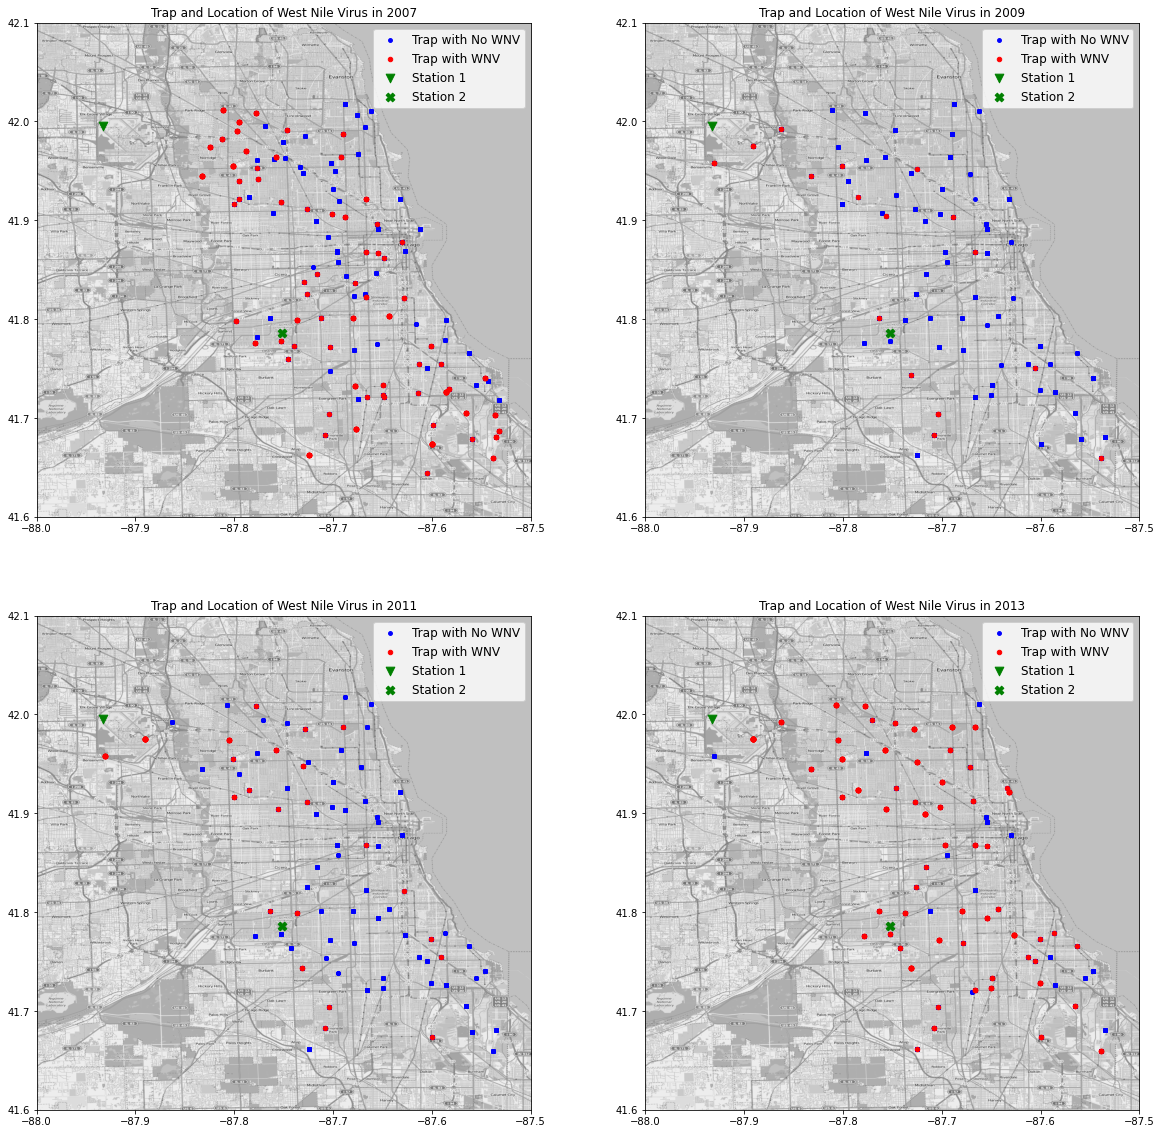

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
ax = ax.ravel()
map_plotter(2007, ax[0])
map_plotter(2009, ax[1])
map_plotter(2011, ax[2])
map_plotter(2013, ax[3])

**Observations:**
- Based on the yearly WNV presence plot, we cannot observe a clear location of a hotspot of the virus outbreak year on year. We do know, though, that some specific trap tends to have a high tendency to find WNV than the other. Therefore, **historical WNV presence** is an important information for us to retain. 

#### Spread of WNV over Time

In [32]:
# Change matplotlib backend
%matplotlib notebook

In [33]:
# The function to be called to plot the datapoints
def scatter_plotter_anim(df, start_date, days_delta, color, marker, size, ax, label):
    ## To define the range of date to show the datafrom
    end_date = start_date + timedelta(days=int(days_delta))
    ## To define latitude and longitude values of each datapoints
    lats = df.loc[str(start_date):str(end_date)]['Latitude']
    longs = df.loc[str(start_date):str(end_date)]['Longitude']
    ## To generate the plot
    ax.scatter(x=longs, y=lats, c=color, s=size, marker=marker, label=label, edgecolors=None)
    
# The function called when the animation starts
def init(start_date):
    ## Call scatter_plotter_anim function to plot the points 
    scatter_plotter_anim(train[train['WnvPresent']==0], start_date, 0, 'b', 'v', 15, ax, 'Trap Location')
    scatter_plotter_anim(train[train['WnvPresent']==1], start_date, 0, 'r', 'o', 15, ax, 'Wnv Present')
    ax.legend()
    ax.set_title("Location of Traps on {}".format(start_date.strftime("%d %b %Y")))
    
# The function to generate the background
def background_generator(year):    
    # Define the plot
    fig, ax = plt.subplots(nrows=1, figsize=(8,8))
    plt.suptitle("For year {}".format(year))
    
    ## Load the map
    mapdata = np.loadtxt("./dataset/mapdata_copyright_openstreetmap_contributors.txt")
    ## lat/long of origin (lower left corner)
    origin = [41.6, -88.0]        
    ## lat/long of upper right corner
    upperRight = [42.1, -87.5]     
    ### Plot the map
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

    # Return the figure and axis to be used by the scatter plotter
    return fig, ax

<IPython.core.display.Javascript object>


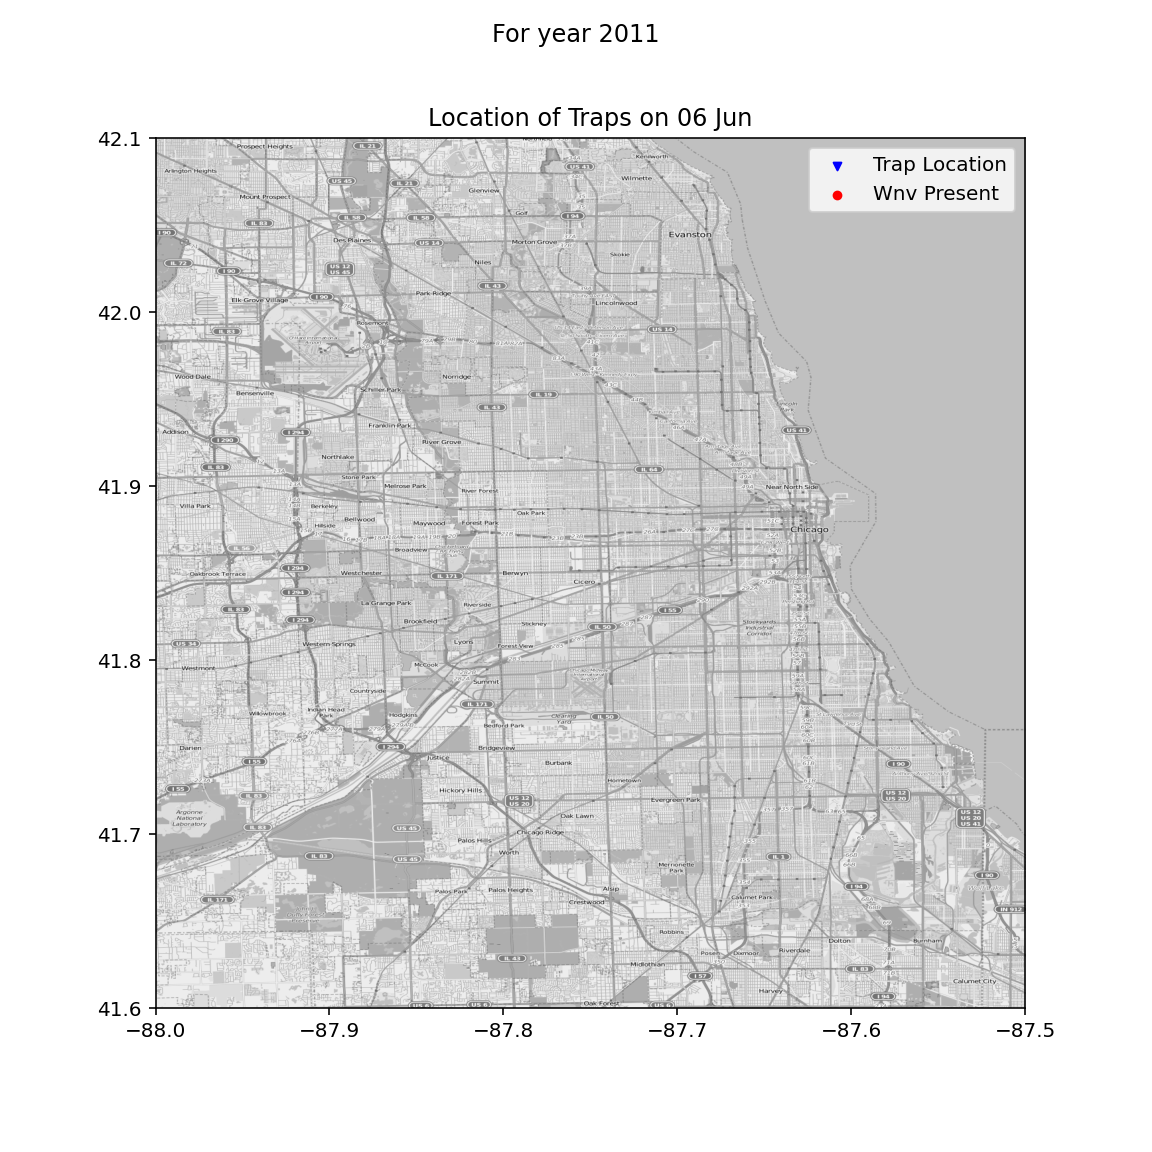

In [34]:
# To call these lines to generate scatter plot animation

## Define start day to show the data from
year = 2011

# ---------------------------------------
# Do not change the code below this point
# ---------------------------------------

## Define start date to show the date from
start_date = datetime(year, 5, 1)
## Generate the background and return figure and its axis
fig, ax = background_generator(year)

## Define a function to update the value of map on every frame
def update_anim(val):
    ## Redefine start_date as FuncAnimation attribute does not take in any variable
    start_date = datetime(year, 5, 1)
    ## Generate the plot
    scatter_plotter_anim(train[train['WnvPresent']==0], start_date, val, 'b', 'v', 15, ax, 'Trap Location')
    scatter_plotter_anim(train[train['WnvPresent']==1], start_date, val, 'r', 'o', 15, ax, 'Wnv Present')
    ## Update the title to show the date
    new_date = start_date + timedelta(days=int(val))
    ax.set_title("Location of Traps on {}".format(new_date.strftime("%d %b")))
    fig.canvas.draw_idle()
    
## Initiate the object FuncAnimation to start the animation
ani = FuncAnimation(fig, func=update_anim, frames=np.linspace(0, 160, 40),
                    init_func=init(start_date), interval=500, repeat=False);

# Set up formatting for the movie files
to_save=0
if to_save:
    Writer = matplotlib.animation.writers['ffmpeg']
    writer = Writer(fps=15, 
                    metadata=dict(title='Traps and Presence of WNV in {}'.format(str(year))),
                    bitrate=-1)
    ani.save('Traps and Presence of WNV in {}.mp4'.format(str(year)), writer=writer)

**Observations:**
- By running the animation 4 times for different years, we can obtain the insight that the virus does not appear on one spot and spread outwards. This further emphasize the previous conclusion we had that there is no clear hotspot where the virus emerges. 

In [35]:
# Return the matplotlib backend
%matplotlib inline

#### Density of Number of Mosquito Caught

In [36]:
def num_mos_plotter(year, ax):

    origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
    upperRight = [42.1, -87.5]          # lat/long of upper right corner

    mapdata = np.loadtxt("./dataset/mapdata_copyright_openstreetmap_contributors.txt")

    intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth

    # generate plot
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

    # points showing the traps
    scatter_plotter(train[train['WnvPresent']==0], str(year), 'b', 'o', 15, ax)
    ax.scatter(x=stat_1_loc[1], y=stat_1_loc[0], c='g', s=50, marker='s')
    ax.scatter(x=stat_2_loc[1], y=stat_2_loc[0], c='g', s=50, marker='X')
    ax.set_title('Density of Number of Mosquitos in {}'.format(year))
    ax.legend(['Trap', 'Station 1', 'Station 2'], fontsize=12)
    
    # Num of Mosquitos Density
    X = train.loc[str(year)][['Longitude', 'Latitude']].drop_duplicates().values
    val = train.loc[str(year)].groupby(['Longitude', 'Latitude'])['NumMosquitos'].sum()
    kd = KernelDensity(bandwidth=0.04)
    kd.fit(X, sample_weight=val)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    
    # Color settings
    alpha_cm = plt.cm.Oranges
    alpha_cm._init()
    alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    vmax = 1200000/train.loc[str(year)].groupby(['Longitude', 'Latitude'])['NumMosquitos'].sum().sum()

    #kernel density
    ax.imshow(zv, origin='lower',
              cmap=alpha_cm, extent=[origin[1], upperRight[1], origin[0], upperRight[0]],
              aspect=aspect,
             vmin=0, vmax=vmax)

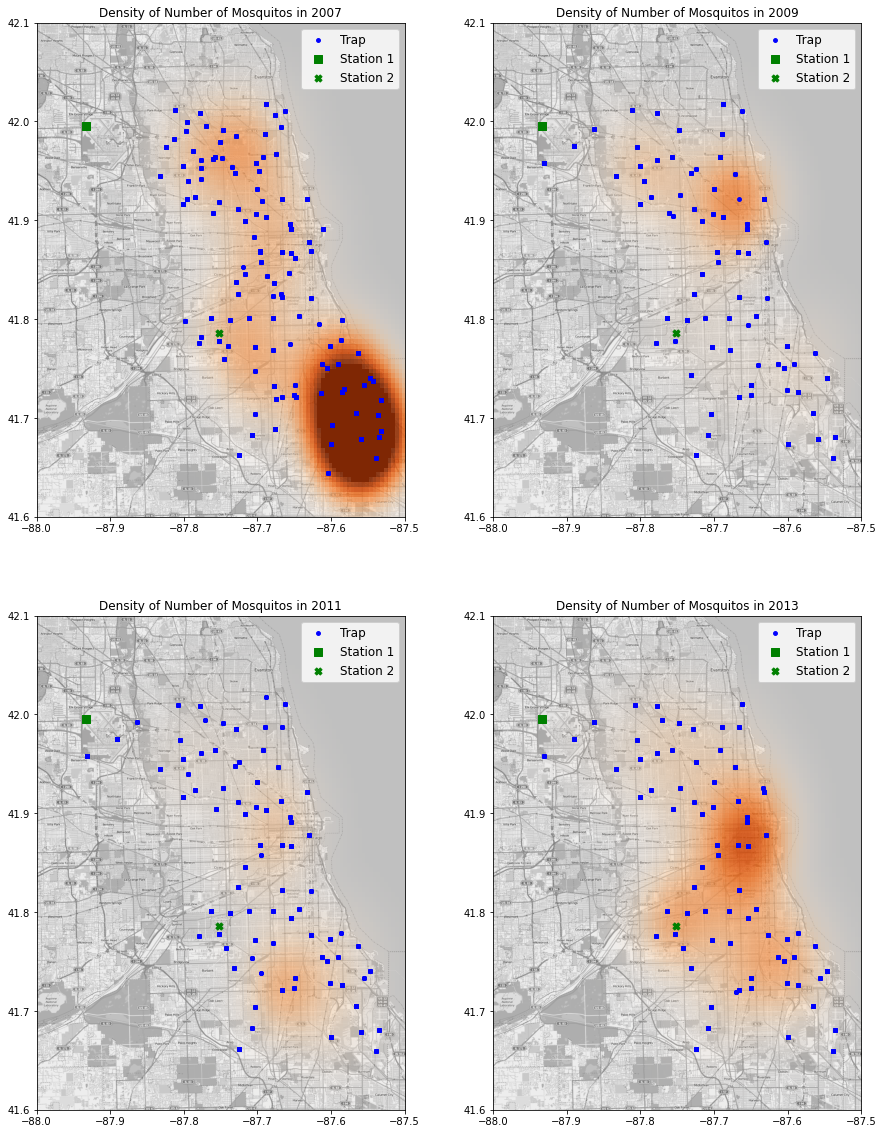

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))
ax = ax.ravel()
num_mos_plotter(2007, ax[0])
num_mos_plotter(2009, ax[1])
num_mos_plotter(2011, ax[2])
num_mos_plotter(2013, ax[3])

**Observations:**

- Note that these four graphs showing differing density of mosquito population. However, we can see the common pattern here is that for all the years, city area always have a noteable presence of mosquito population (with slight exception of 2007 when the mosquito population is less obvious due to high presence of mosquito at the South). 

#### Effect of Number of Mosquito on the Sprayed Location

In [38]:
def density_plotter(df, time, ax, for_spray):
    year = time[0:4]
    origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
    upperRight = [42.1, -87.5]          # lat/long of upper right corner

    mapdata = np.loadtxt("./dataset/mapdata_copyright_openstreetmap_contributors.txt")

    intersection = [41.909614, -87.746134]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth

    # Draw Map
    ax.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])
    if for_spray:
        ax.set_title('Spray Density Plot on {}'.format(time))
        handle = mpatches.Patch(facecolor=plt.cm.Blues(200), label='Spray Locations')
    else:
        ax.set_title('Mosquito Density Plot on {}'.format(time))
        handle = mpatches.Patch(facecolor=plt.cm.Oranges(200), label='Mosquito Density')
    
    # Generate Density
    kd = KernelDensity(bandwidth=0.04)
    X = df[df.index==time][['Longitude', 'Latitude']].drop_duplicates().values
    if for_spray:
        kd.fit(X)
    else:
        val = df[df.index==time].groupby(['Longitude', 'Latitude'])['NumMosquitos'].sum()
        kd.fit(X, sample_weight=val)
        
    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    
    # Color settings
    if for_spray:
        alpha = plt.cm.Blues
        vmin = None
        vmax = None
    else:
        alpha = plt.cm.Oranges
        vmin = None
        vmax = 60000 / df[df.index==time].groupby(['Longitude', 'Latitude'])['NumMosquitos'].sum().sum()
        
    alpha._init()
    alpha._lut[:-3,-1] = abs(np.logspace(0, 1, alpha.N) / 10 - 1)[::-1]

    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

    #kernel density
    ax.imshow(zv, origin='lower', cmap=alpha, 
              extent=[origin[1], upperRight[1], origin[0], upperRight[0]], 
              aspect=aspect, vmin=vmin, vmax=vmax)    
    
    ax.legend(handles=[handle])

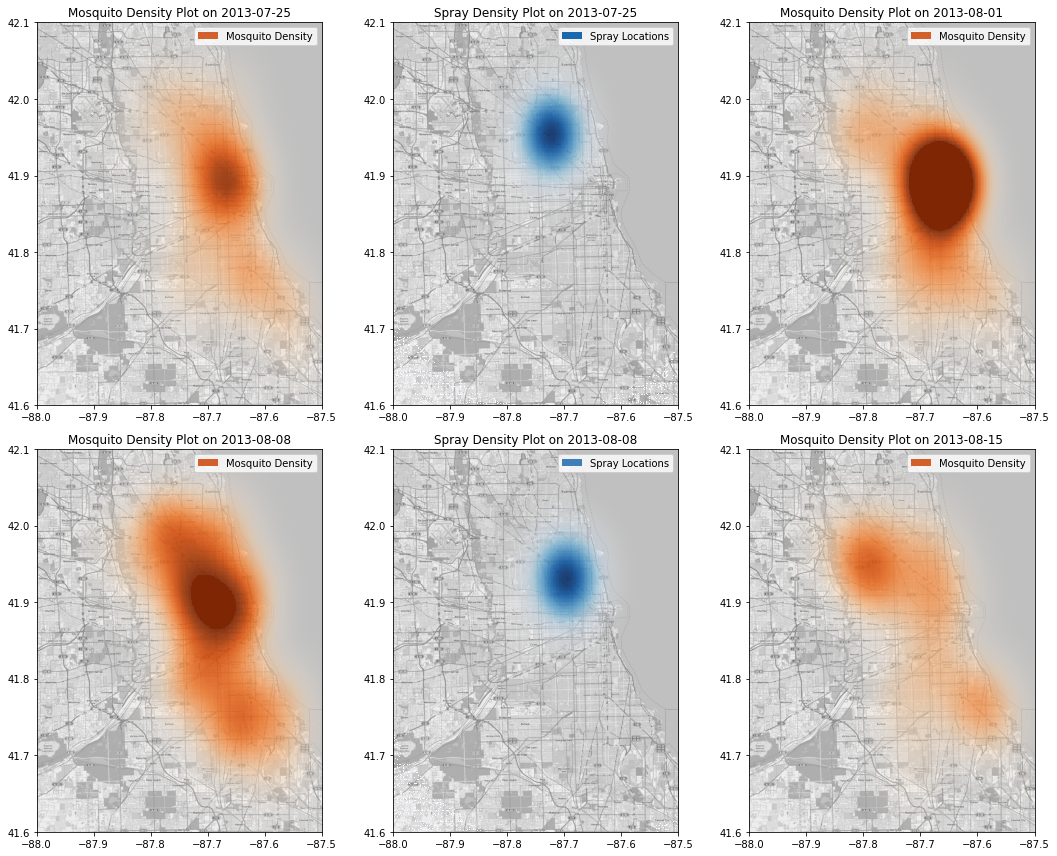

In [39]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,12))
ax = ax.ravel()
density_plotter(train, '2013-07-25', ax[0], 0)
density_plotter(spray, '2013-07-25', ax[1], 1)
density_plotter(train, '2013-08-01', ax[2], 0)
density_plotter(train, '2013-08-08', ax[3], 0)
density_plotter(spray, '2013-08-08', ax[4], 1)
density_plotter(train, '2013-08-15', ax[5], 0)
plt.tight_layout()

## Mosquito Species

### Population per Species

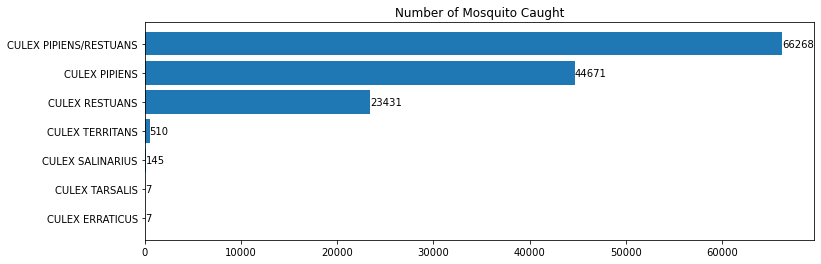

In [40]:
fig, ax = plt.subplots(figsize=(12, 4))
mos_species = train.groupby(['Species'])['NumMosquitos'].sum().sort_values(ascending=True)
ax.barh(y=mos_species.index, width=mos_species);
for no, population in enumerate(mos_species):
    ax.text(population, no, population, va='center')
ax.set_title('Number of Mosquito Caught');

**Observations:**
- Most of the mosquito species are from three species, i.e. 'CULEX PIPIENS/ RESTUANS', 'CULEX PIPIENS', and 'CULEX RESTUANS'. The other four species barely accounts for 1% of total mosquito caught.

### Mosquito with Virus per Species

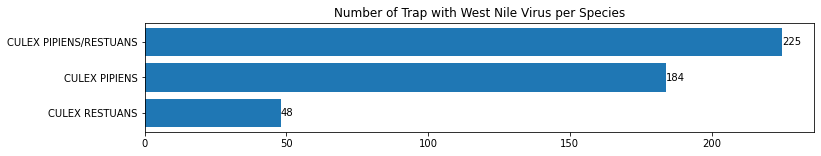

In [41]:
fig, ax = plt.subplots(figsize=(12, 2))
wnv_species = train[train['WnvPresent']==1].groupby(['Species'])['WnvPresent'].sum().sort_values(ascending=True)
ax.barh(y=wnv_species.index, width=wnv_species)
for no, population in enumerate(wnv_species):
    ax.text(population, no, population, va='center')
ax.set_title('Number of Trap with West Nile Virus per Species');

**Observations:**
- As expected, majority species of mosquitos are the main carriers of the West Nile Virus. However, we note that we may not have caught enough the minority Culex types of mosquitos to know whether or not they truly do not carry the virus.

### Percentage of Infection Rate

In [42]:
percent_ir = pd.DataFrame(wnv_species).merge(pd.DataFrame(mos_species), 
                                             left_index=True, right_index=True, how='left')
percent_ir['infection_rate'] = percent_ir['WnvPresent'] / percent_ir['NumMosquitos']
percent_ir

WnvPresent  NumMosquitos  infection_rate
Species                                                         
CULEX RESTUANS                  48         23431        0.002049
CULEX PIPIENS                  184         44671        0.004119
CULEX PIPIENS/RESTUANS         225         66268        0.003395

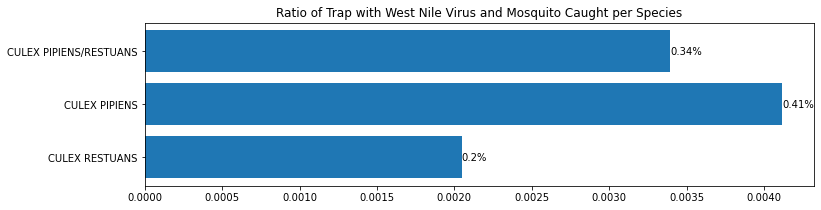

In [43]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.barh(y=percent_ir.index, width=percent_ir['infection_rate'])
for no, population in enumerate(percent_ir['infection_rate']):
    ax.text(population, no, str(round(population*100,2)) + '%', va='center')
ax.set_title('Ratio of Trap with West Nile Virus and Mosquito Caught per Species');

**Observations:**
- Despite being the second most common mosquito species, 'CULEX PIPIENS' is observed to have the highest infection rate of all the mosquito species.

## File Export (EDA)

In [44]:
train.to_csv('dataset/train_EDA.csv')
test.to_csv('dataset/test_EDA.csv')
weather.to_csv('dataset/weather_EDA.csv')